In [1]:
'''
author: Yike Xie
data: 22/2/2023
content: correlate image features and transcriptome
'''

'\nauthor: Yike Xie\ndata: 22/2/2023\ncontent: correlate image features and transcriptome\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def get_correlation(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    x = exp #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata_s, fea, xlabel, path, filetype=False):
    '''
    genes = {
    'positive': [],
    'negative': []
    }
    '''
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata_s.obs[fea]
            y = adata_s[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = int(exp.shape[0] / bin_n)
        idx = np.arange(n) + n * i
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median()
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/max(med) for i in med]
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}: smallest → largest'.format(fea.title()))
    ax.set_title(gene)
    ax.set_yscale('log')

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)
adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.var` of view, copying.


filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [11]:
if False:
    # Average spectra among all channels
    adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']
    
    print('Correlate with some simple features')
    # correlations between areas and gene expressions at single cell resolution
    feas = ['area', 'eccentricity', 'spectra_norm']
    corr = get_correlation(adata, feas)
    corr.to_csv(save_figures + 'correlation.tsv', sep='\t')

Correlate with some simple features


In [5]:
print('filter genes')

corr = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/version2_96cells/correlation.tsv',
                  sep='\t', index_col=0)

# percentage of cells expressing this gene
pct = 0.8
gene_pct = pd.Series((adata.X > 0).sum(axis=0) / adata.obs.shape[0], index=adata.var_names)
high_pct = gene_pct[gene_pct >= pct].index

filter genes


In [22]:
df = pd.read_csv('/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/version2_96cells/GSEAPY_area_neg300.tsv', 
                 sep='\t', index_col=0)
splicing_genes = df.loc[[2, 3, 4, 6]]['Genes'].str.split(';')
splicing_genes = np.unique(splicing_genes.iloc[0] + splicing_genes.iloc[1] + 
                           splicing_genes.iloc[2] + splicing_genes.iloc[3])
s_high = [gene for gene in splicing_genes if gene in high_pct]

In [47]:
corr.loc[s_high]

,area,eccentricity,spectra_norm
gene_name,,,
AHNAK,-0.196010,-0.050645,0.296404
HNRNPC,-0.171657,-0.031830,-0.074519
NCL,-0.192827,-0.009021,0.317611
POLR2A,-0.221420,0.012040,0.464709
RPS26,-0.182041,-0.081227,0.019866
SF3B4,-0.212832,-0.020941,0.230212
SLC38A2,-0.180296,-0.039890,0.403338
SRRM1,-0.225266,-0.151402,0.180255
TRA2B,-0.214205,-0.063803,0.206826


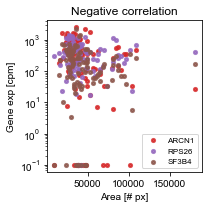

In [59]:
genes = ['ARCN1', 'RPS26', 'SF3B4']
fig, ax = plt.subplots(figsize=[3, 3])
# rcParams['pdf.fonttype'] = 42
# rcParams['font.sans-serif'] = "Arial"
    
fea = 'area'
xlabel = 'Area [# px]'
colors = sns.color_palette('tab10', 6)[3:]

for ig, gene in enumerate(genes):
    x = adata.obs[fea]
    y = adata[:, gene].X + 0.1
    idx = np.argsort(x)
    ax.scatter(
        x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[ig], s=10, 
    )
ax.legend(fontsize=8, loc='best')
ax.set_xlabel(xlabel)
ax.set_ylabel('Gene exp [cpm]')
ax.set_yscale('log')
#         ax.set_xscale('log')

ax.set_title('Negative correlation')
fig.tight_layout()
fig.savefig(save_figures + 'new_area_neg.pdf', dpi=150, bbox_inches='tight')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


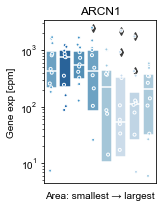

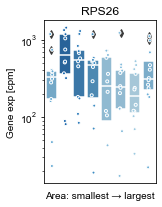

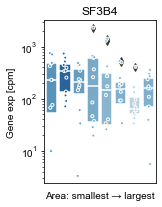

In [61]:
for gene in genes:
    cmap = 'Blues'
    bin_n = 8
    path = save_figures
    fea = 'area'

    plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path=save_figures)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


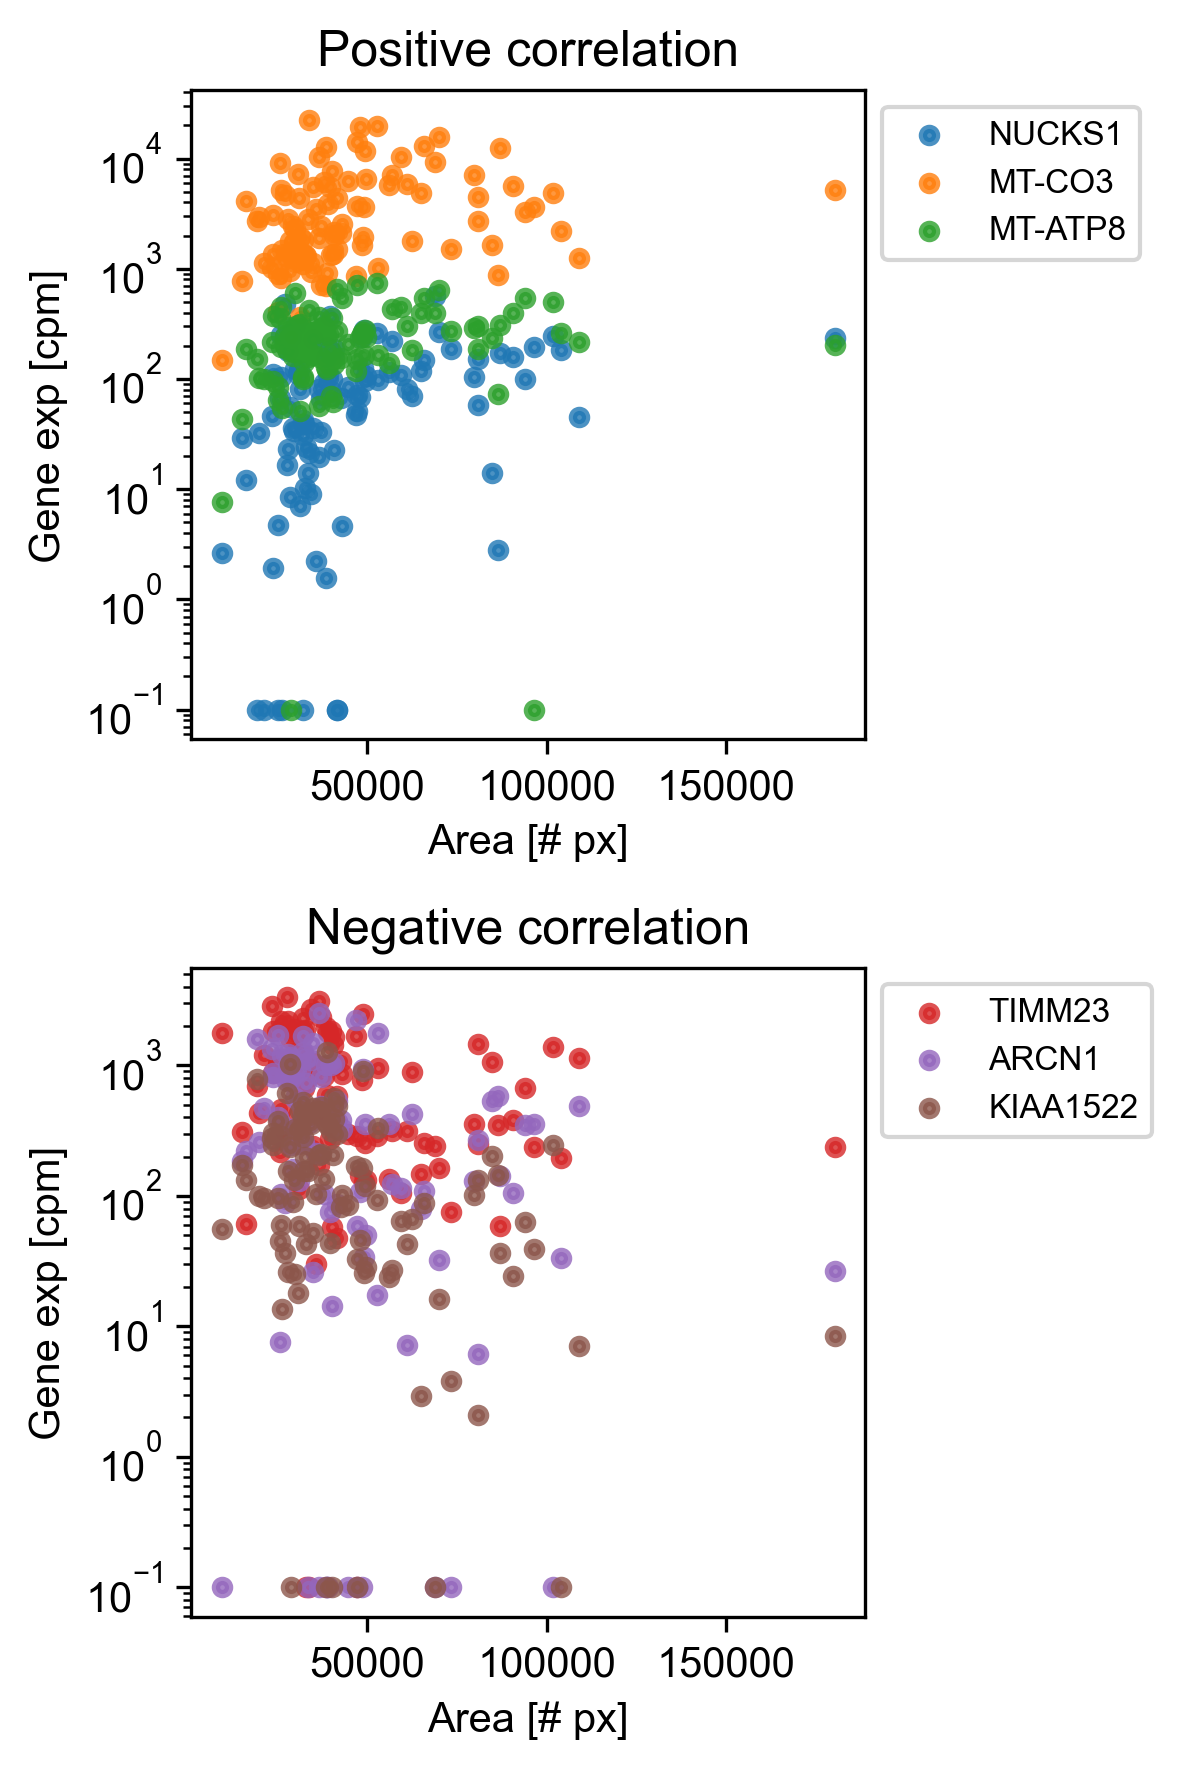

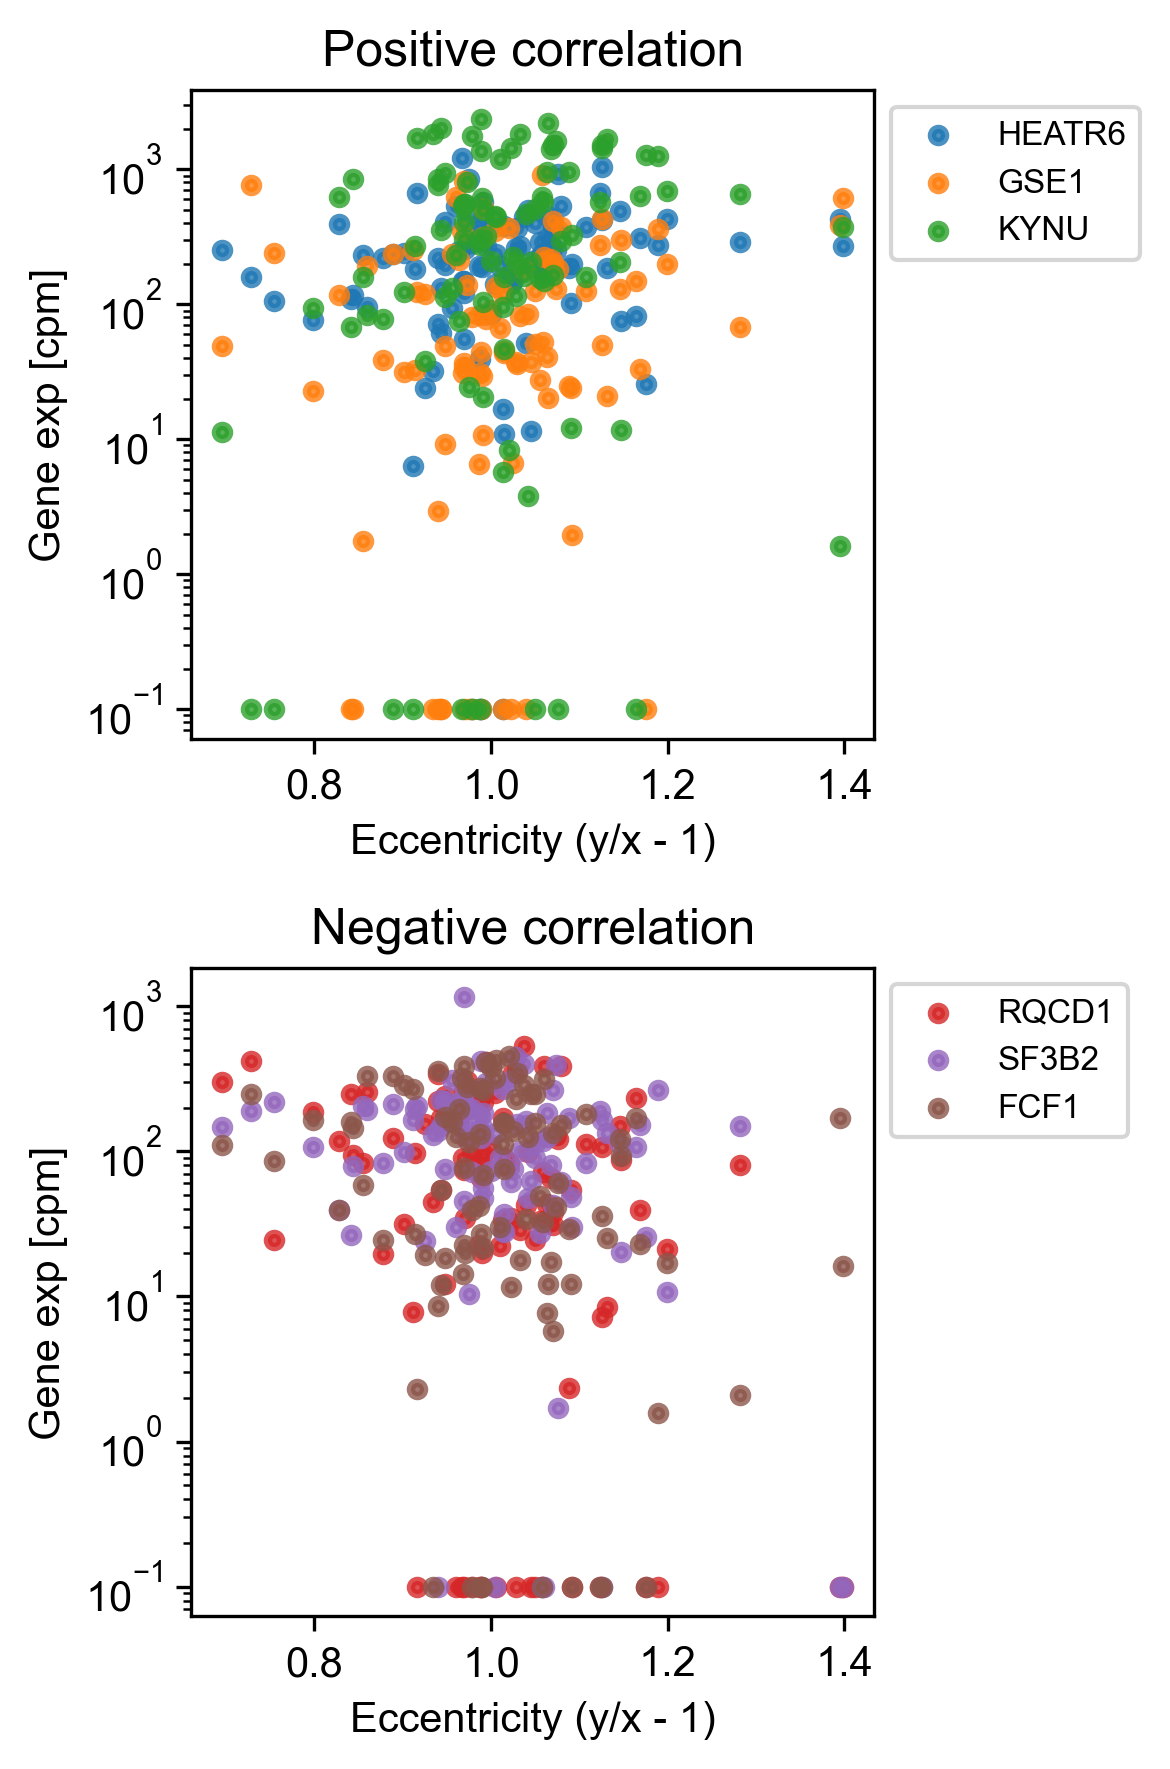

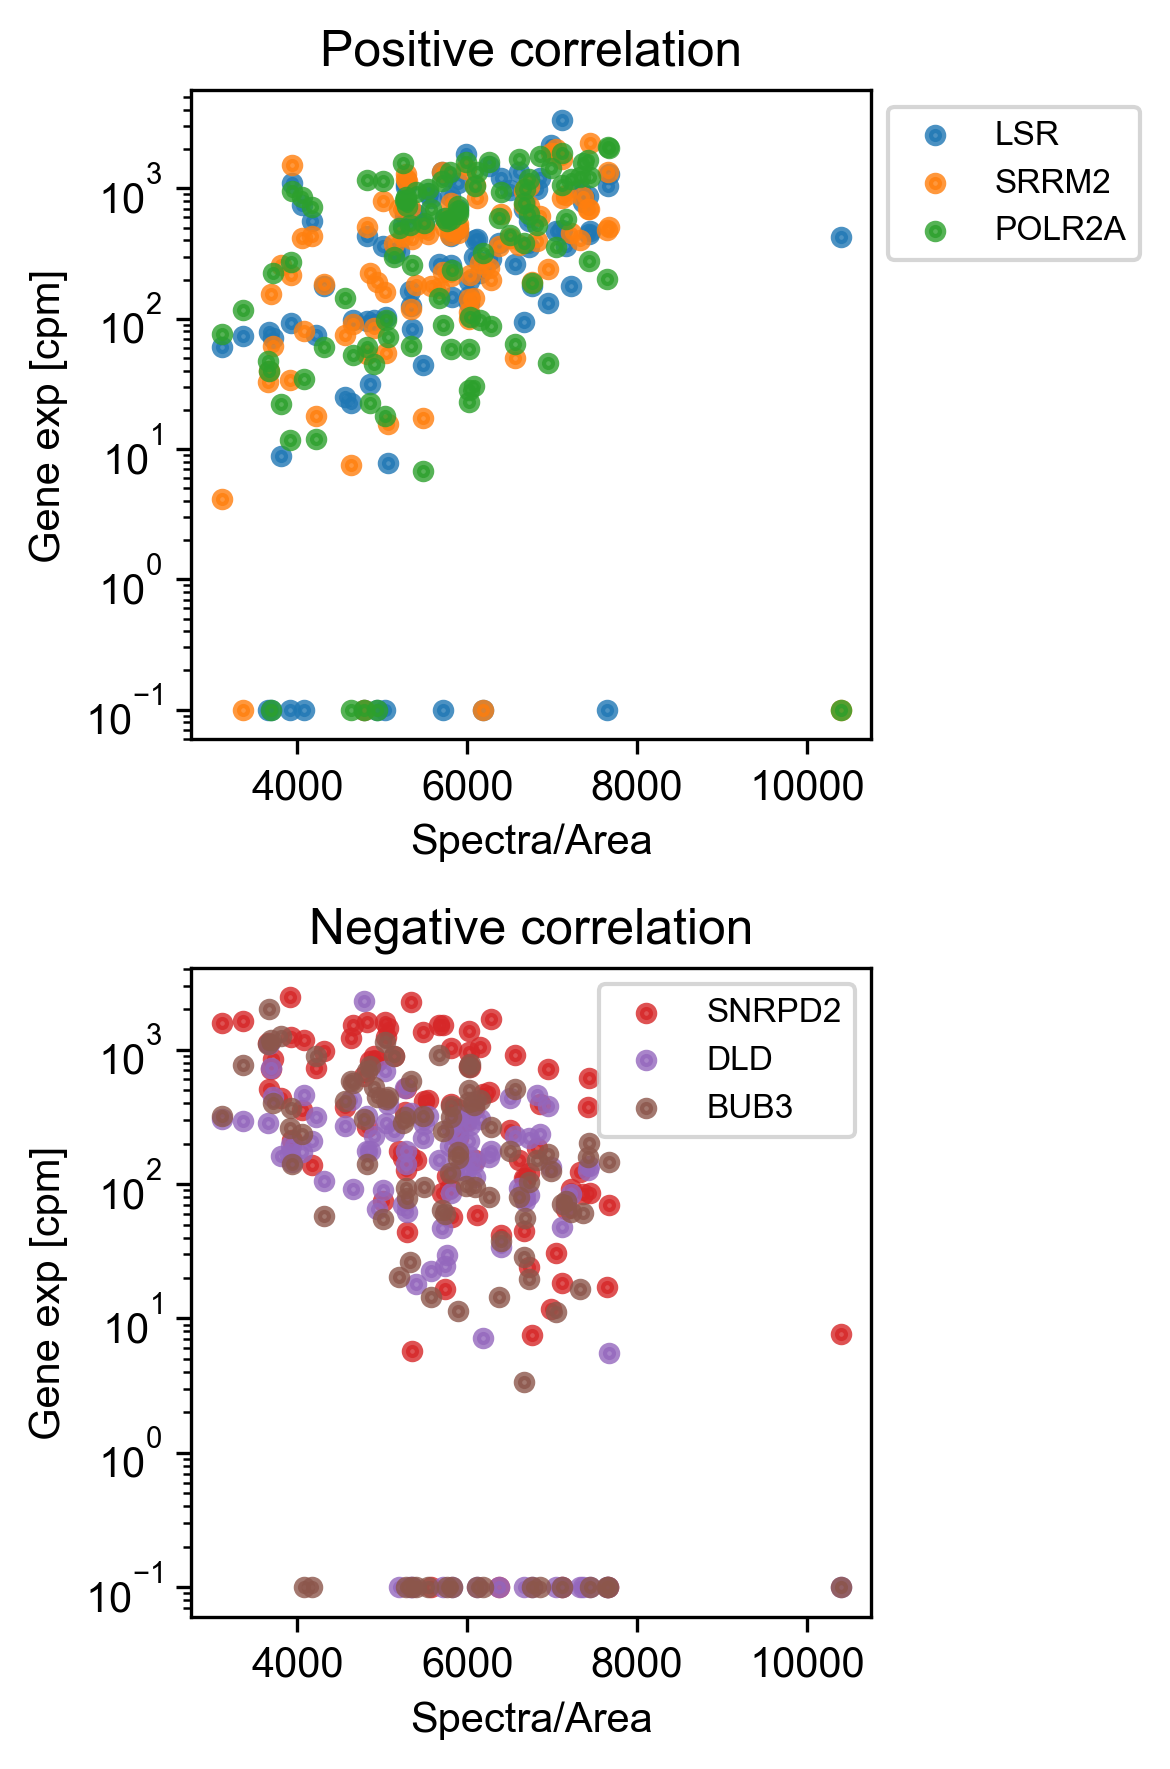

In [36]:
feas = ['area', 'eccentricity', 'spectra_norm']
xlabels = ['Area [# px]', 'Eccentricity (y/x - 1)', 'Spectra/Area']

adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']

for fea, xlabel in zip(feas, xlabels):
    pos_genes = corr.loc[high_pct].nlargest(3, fea).index
    neg_genes = corr.loc[high_pct].nsmallest(3, fea).index

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': pos_genes,
        'negative': neg_genes,
    }
    plot_correlation(genes, adata, fea, xlabel, path, filetype='.pdf')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

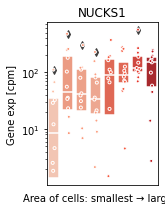

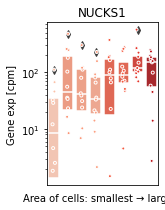

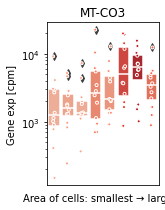

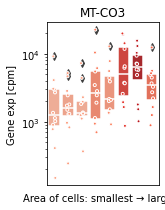

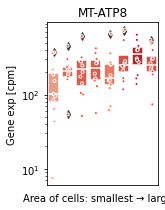

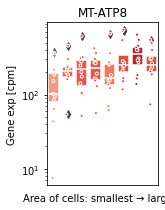

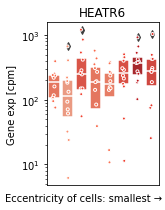

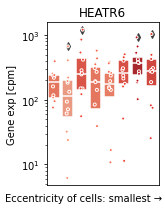

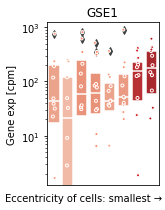

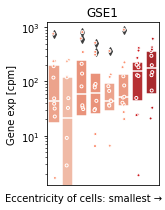

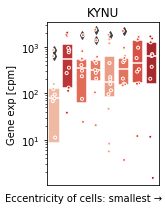

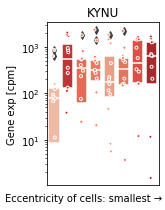

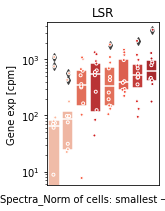

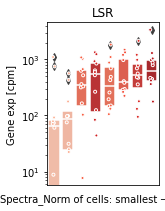

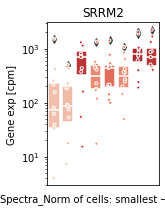

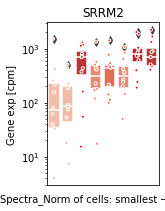

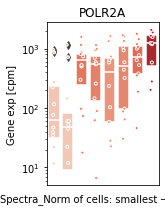

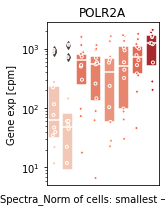

In [152]:
feas = ['area', 'eccentricity', 'spectra_norm']

for fea in feas:
    pos = corr.loc[high_pct].nlargest(3, fea).index

    for gene in pos:
        cmap = 'Reds'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

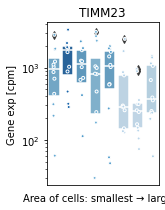

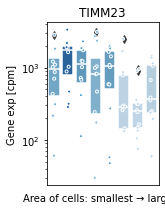

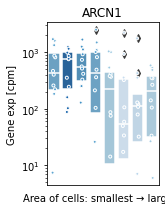

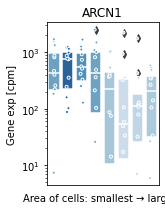

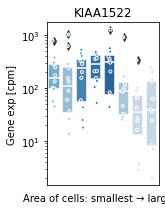

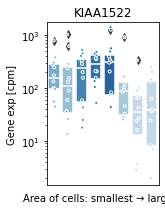

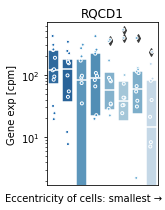

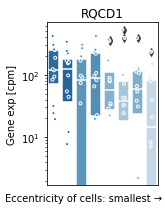

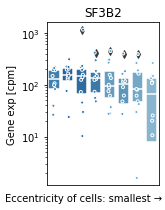

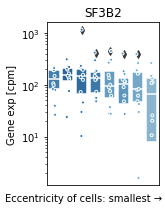

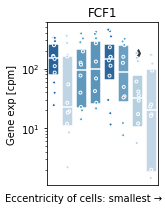

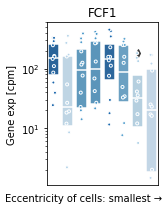

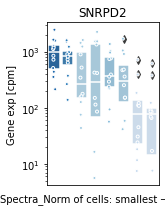

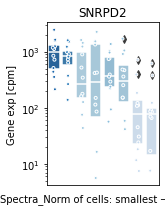

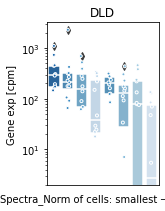

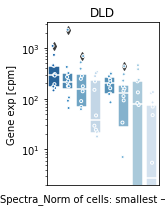

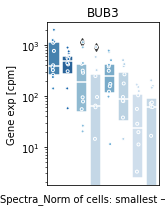

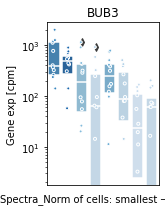

In [153]:
feas = ['area', 'eccentricity', 'spectra_norm']

for fea in feas:
    negs = corr.loc[high_pct].nsmallest(3, fea).index

    for gene in negs:
        cmap = 'Blues'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

### area pathway analysis

In [30]:
import gseapy as gp
from gseapy.plot import barplot

def gsea_analysis(genes, path, fn, title):
    res = gp.enrichr(gene_list=genes,
                     gene_sets=['GO_Biological_Process_2021'],
                     description='pathway',
                     cutoff = 0.05)
    if fn is not False:
        res.res2d.to_csv(os.path.join(path, fn + '.tsv'), sep='\t')

    barplot(res.res2d, column='P-value', title=title, ofname=os.path.join(path, fn + '.svg')) 

In [19]:
pos300 = corr['area'].fillna(0).sort_values()[-300:].index.tolist()
neg300 = corr['area'].fillna(0).sort_values()[:300].index.tolist()

gsea_analysis(pos_genes, save_figures, 'GSEAPY_area_pos300', 'Pathways positively correlated with area')
gsea_analysis(neg_genes, save_figures, 'GSEAPY_area_neg300', 'Pathways negatively correlated with area')

### eccentricity pathway analysis

In [23]:
pos300 = corr['eccentricity'].fillna(0).sort_values()[-300:].index.tolist()
neg300 = corr['eccentricity'].fillna(0).sort_values()[:300].index.tolist()

gsea_analysis(pos_genes, save_figures, 'GSEAPY_eccentricity_pos300', 
              'Pathways positively correlated with eccentricity')
gsea_analysis(neg_genes, save_figures, 'GSEAPY_eccentricity_neg300', 
              'Pathways negatively correlated with eccentricity')